# Imports

In [1]:
import cvxpy
import matplotlib.pyplot as plt
import numpy
import numpy.random
from scipy.optimize import least_squares
from tqdm.notebook import tqdm

%run unit_exponentials.ipynb

# Hyperparameters

In [2]:
# Number of unit exponentials to add
n = 7
#n = 25

# Boundaries of multiplier arguments
min_k = 1.25
max_k = 2.25
#min_k = 1.01
#max_k = 1.25

# Maximum weight multiplier
r = 3

# Initial value for weights
default_w = 0.5

# Initial value for k_0
default_initial_k = 0.5

# Initial value for other k_j
default_k = 2
#default_k = 1.1

# Sums of unit exponentials

In [3]:
# params should be an array [k_0,w_1,k_1,w_2,...,w_n]
def uexp_sum(params, n=n, **kwargs):
    k0 = params[0]
    cur_t = k0
    cur_w = params[1]
    uexps = [uexp(cur_t)]
    ww = [cur_w]

    for i in range(1,n):
        cur_k = params[2*i]
        cur_t = cur_t * cur_k
        uexps.append(uexp(cur_t))
        
        cur_w = params[2*i+1]
        ww.append(cur_w)

    def uexp_sum_f(x):
        result = 0.0
        for i in range(n):
            w = ww[i]
            uexp_f = uexps[i]

            result += w * uexp_f(x)

        return result

    return uexp_sum_f

In [4]:
def uexp_sum_str(params, n=n, **kwargs):
    k0 = params[0]
    cur_t = k0
    cur_w = params[1]

    result = f"{cur_w:.2f}uexp({cur_t:.2f})"

    for i in range(1,n):
        cur_k = params[2*i]
        cur_t = cur_t * cur_k
        cur_w = params[2*i+1]
        result += f" + {cur_w:.2f}uexp({cur_t:.2f})"

    return result

# Least squares fitting

In [5]:
def residuals_absolutely_monotonic_fit_parametric(params, xx, yy, **kwargs):            
    f = uexp_sum(params, **kwargs)

    fxx = f(xx)
    
    return yy - fxx
    
def absolutely_monotonic_fit_parametric(xx, yy, n=n,min_k=min_k,max_k=max_k,default_initial_k=default_initial_k,default_k=default_k,default_w=default_w,r=r,**kwargs):        
    max_y = numpy.max(yy)
    
    min_bounds = [0,0]
    max_bounds = [max_k,r*max_y]
    initial_params = [default_initial_k,default_w]
    
    for i in range(1,n):
        min_bounds.append(min_k)
        min_bounds.append(0)
        max_bounds.append(max_k)
        max_bounds.append(r*max_y)
        initial_params.append(default_k)
        initial_params.append(default_w)
    
    residuals_lambda = lambda params:residuals_absolutely_monotonic_fit_parametric(params,xx,yy,n=n,**kwargs)    
    
    result = least_squares(residuals_lambda, initial_params, bounds=(min_bounds,max_bounds))

    return result.x

# Evaluation

In [6]:
def generate_sample(f,number_samples=200,gaussian_noise_std_mult=0,**kwargs):       
    xx = numpy.sort(numpy.random.random_sample(number_samples))
    yy = f(xx)

    # Add noise
    if gaussian_noise_std_mult > 0:
        noise = numpy.random.normal(scale=gaussian_noise_std_mult*f(1),size=number_samples)        
    else:
        noise = 0

    return (xx,yy+noise)

number_samples_test=200
# Returns a dictionary with entries:
#  - xx
#  - yy
#  - params
#  - fit_nmse
#  - source_nmse
def evaluate_absolutely_monotonic_fit(f,number_samples,number_samples_test=number_samples_test,**kwargs):
    (xx,yy) = generate_sample(f,number_samples=number_samples,**kwargs)

    params = absolutely_monotonic_fit_parametric(xx,yy,**kwargs)

    fit_residuals = residuals_absolutely_monotonic_fit_parametric(params, xx, yy, **kwargs)

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    source_residuals = residuals_absolutely_monotonic_fit_parametric(params, xx2, yy2, **kwargs)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy": yy, "params":params, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

In [24]:
def plot_absolutely_monotonic_fit(f, f_desc, params, xx, yy, **kwargs):    
    oo = numpy.linspace(0,1,200)
    
    original_ff = f(oo)

    fitted_f = uexp_sum(params,**kwargs)
    fitted_ff = fitted_f(oo)
    
    plt.plot(oo,original_ff,c="c",linestyle="dotted",alpha=1,label=f_desc)
    plt.plot(oo,fitted_ff,c="r",linestyle="dashed",alpha=1,label=uexp_sum_str(params,**kwargs))
    plt.scatter(xx,yy,c="k",alpha=0.1,marker="x",label="Fit to sampled points")   

In [25]:
# Using cvxpy
def cvxpy_fit(f, xx, yy, number_samples_test=number_samples_test,**kwargs):
    l = len(xx)
    ff_var = cvxpy.Variable(l)

    objective = cvxpy.Minimize(cvxpy.sum_squares(ff_var - yy))

    constraints = [
        ( (ff_var[i+2] - ff_var[i+1]) / (xx[i+2] - xx[i+1]) -
          (ff_var[i+1] - ff_var[i]) / (xx[i+1] - xx[i]) ) >= 0
        for i in range(l - 2)
    ]

    problem = cvxpy.Problem(objective, constraints)
    problem.solve()

    ff = ff_var.value

    fit_residuals = ff-yy

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    ff2 = numpy.interp(xx2,xx,ff)
    source_residuals = ff2-yy2

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy":yy, "ff":ff, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

def plot_cvxpy_fit(f, f_desc, xx, ff, **kwargs):    
    plt.plot(xx,ff,c="y",linestyle="dashdot",alpha=1,label="Convex fit")

In [9]:
number_tests = 100
def absolutely_monotonic_fit_many(f,number_samples,number_tests=number_tests,**kwargs):
    results = []
    #for i in tqdm(range(number_tests)):
    for i in range(number_tests):
        result = evaluate_absolutely_monotonic_fit(f,number_samples,**kwargs)

        results.append(result)

        if i % 10 == 9:
            print(f"{i+1} tests completed")

    results_source_nmse = numpy.array([result["source_nmse"] for result in results])

    max_source_nmse = numpy.max(results_source_nmse)
    avg_source_nmse = numpy.average(results_source_nmse)
    avg_diffs = numpy.abs(results_source_nmse - avg_source_nmse)
    min_avg_diff = numpy.min(avg_diffs)

    max_result = [result for result in results if result["source_nmse"] == max_source_nmse][0]
    avg_result = [result for result in results if numpy.abs(result["source_nmse"]-avg_source_nmse) == min_avg_diff][0]

    return {"max_source_nmse":max_source_nmse, "avg_source_nmse":avg_source_nmse, "avg_result":avg_result, "worst_result":max_result}

In [10]:
def plot_full_result_absolutely_monotonic_fit(fit_function, function_desc,
                                              number_samples, number_samples_test, gaussian_noise_std_mult,
                                              result):
    params = result["params"]
    xx = result["xx"]
    yy = result["yy"]
    fit_nmse = result["fit_nmse"]
    source_nmse = result["source_nmse"]
    
    result_cvxpy = cvxpy_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test)
    
    ff_cvxpy = result_cvxpy["ff"]
    fit_nmse_cvxpy = result_cvxpy["fit_nmse"]
    source_nmse_cvxpy = result_cvxpy["source_nmse"]                        
    
    
    if gaussian_noise_std_mult == 0:
        plot_title = f"Absolutely monotonic fit for {function_desc} (N={number_samples})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
    else:
        plot_title = f"Absolutely monotonic fit for {function_desc} (N={number_samples}, gaussian noise std={gaussian_noise_std_mult:.2f})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
        
    plot_absolutely_monotonic_fit(fit_function,function_desc,params,xx,yy)
    plot_cvxpy_fit(fit_function,function_desc,xx,ff_cvxpy)
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    
    plt.title(plot_title)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize="x-small")
        
    plt.show()

## Evaluated functions

In [19]:
f1_desc = uexp_sum_str([2.5,0.3,10.35/2.5,2.6,53.4/10.35,1.24],n=3)
uexp1 = uexp(2.5)
uexp2 = uexp(10.35)
uexp3 = uexp(53.4)
def f1(x):
    return 0.3*uexp1(x) + 2.6*uexp2(x) + 1.24*uexp3(x)

f2_desc = "e^(e^x) - normalized"
f2_zero = numpy.exp(1)
f2_factor = numpy.divide(1.0,numpy.exp(numpy.exp(1))-f2_zero)
def f2(x):
    return f2_factor*(numpy.exp(numpy.exp(x)) - f2_zero)

f3_desc = "e^(e^(e^x)) - normalized"
f3_zero = numpy.exp(numpy.exp(1))
f3_factor = numpy.divide(1.0,numpy.exp(numpy.exp(numpy.exp(1)))-f3_zero)
def f3(x):
    return f3_factor*(numpy.exp(numpy.exp(numpy.exp(x))) - f3_zero)

f4_desc = "x^2"
def f4(x):
    return x*x

f5_desc = "x^5+2x^4+x^3+x"
def f5(x):
    return numpy.power(x,5) + 2*numpy.power(x,4) + numpy.power(x,3) + x

f6_desc = "3x^2-x^3"
def f6(x):
    return 3*numpy.power(x,2) - numpy.power(x,3)

f7_desc = "x^4-4x^3+6x^2"
def f7(x):
    return numpy.power(x,4)-4*numpy.power(x,3)+6*numpy.power(x,2)

f8_desc = "sin(pi/2 x - pi/2) + 1"
def f8(x):
    return numpy.sin(x*numpy.pi/2 - numpy.pi/2) + 1

f9_desc = "4x^2 {[0,0.5]} || 4x-1 {[0.5,1]}"
def f9(x):
    return numpy.where(x < 0.5, 4*numpy.power(x,2), 4*x-1)

10 tests completed
20 tests completed
30 tests completed
40 tests completed
50 tests completed
60 tests completed
70 tests completed
80 tests completed
90 tests completed
100 tests completed


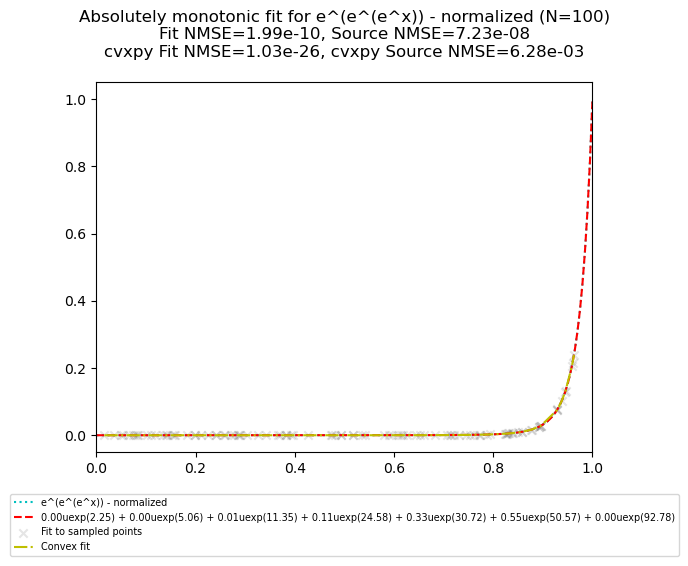

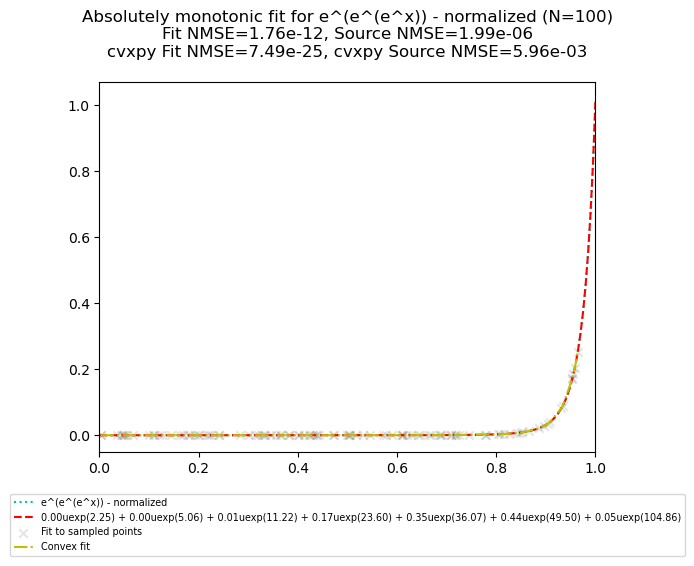

In [35]:
number_samples = 100
number_samples_test=200
number_tests = 100
gaussian_noise_std_mult=0
fit_function = f3
function_desc = f3_desc

many_results = absolutely_monotonic_fit_many(fit_function, number_samples, number_tests, gaussian_noise_std_mult=gaussian_noise_std_mult)

avg_result = many_results["avg_result"]
worst_result = many_results["worst_result"]

plot_full_result_absolutely_monotonic_fit(fit_function, function_desc, number_samples, number_samples_test, gaussian_noise_std_mult, avg_result)
plot_full_result_absolutely_monotonic_fit(fit_function, function_desc, number_samples, number_samples_test, gaussian_noise_std_mult, worst_result)